## This is the EDA notebook.

In [1]:
# Necessary installs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
# Load the Datasets
df_values = pd.read_csv('data/train_values.csv', index_col = 'building_id')
df_labels = pd.read_csv('data/train_labels.csv', index_col = 'building_id')

Because we are looking into the predicting total damage grade caused by the features of the house, house information such as building uses, secondard building uses, and ownership should have no effect in the overall damage caused by an earthquake. Thus, we dropped those columns, reducing our dataset about 33%.

In [3]:
df_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [4]:
# The Secondary Uses of the building nor the ownership should have a factor in determining earthquake damage
# so removing them from our dataset made the most sense.
selected_features = df_values.columns[:25]
features_list = []

for feature in selected_features:
    features_list.append(feature)
    
train_values_subset = df_values[features_list]

In [5]:
train_values_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [6]:
data_viz = train_values_subset.join(df_labels)

Because we are focused on the features of completely destroyed buildings, we grouped 'damage_grade' == 1 and 'damage_grade' == 2 as one category.

In [7]:
def damage_classifier(val):
    if val == 3:
        return 1
    else:
        return 0
data_viz['damage_grade'] = data_viz['damage_grade'].map(damage_classifier)

In [61]:
# Define a new name so we can easily refer back to this 'final' dataset
major_damage = data_viz

In [62]:
data_viz.damage_grade.value_counts()

0    173383
1     87218
Name: damage_grade, dtype: int64

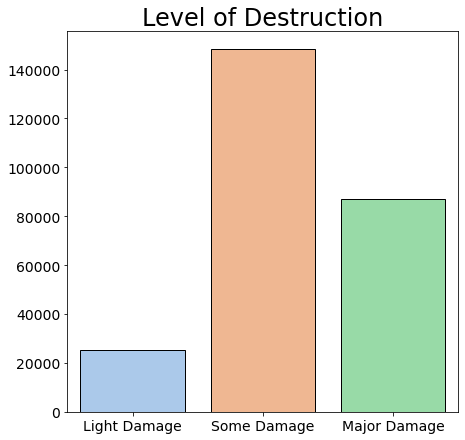

In [9]:
# Graphic of damage types.
y = [25124, 148259, 87218]
x = ['Light Damage', 'Some Damage', 'Major Damage']

plt.figure(figsize=(7,7))
sns.barplot(x=x, y=y, edgecolor='black', palette='pastel')
plt.title('Level of Destruction', fontsize=24)
# plt.xlabel('', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Plot a heat map to show indications of multicollinearity.

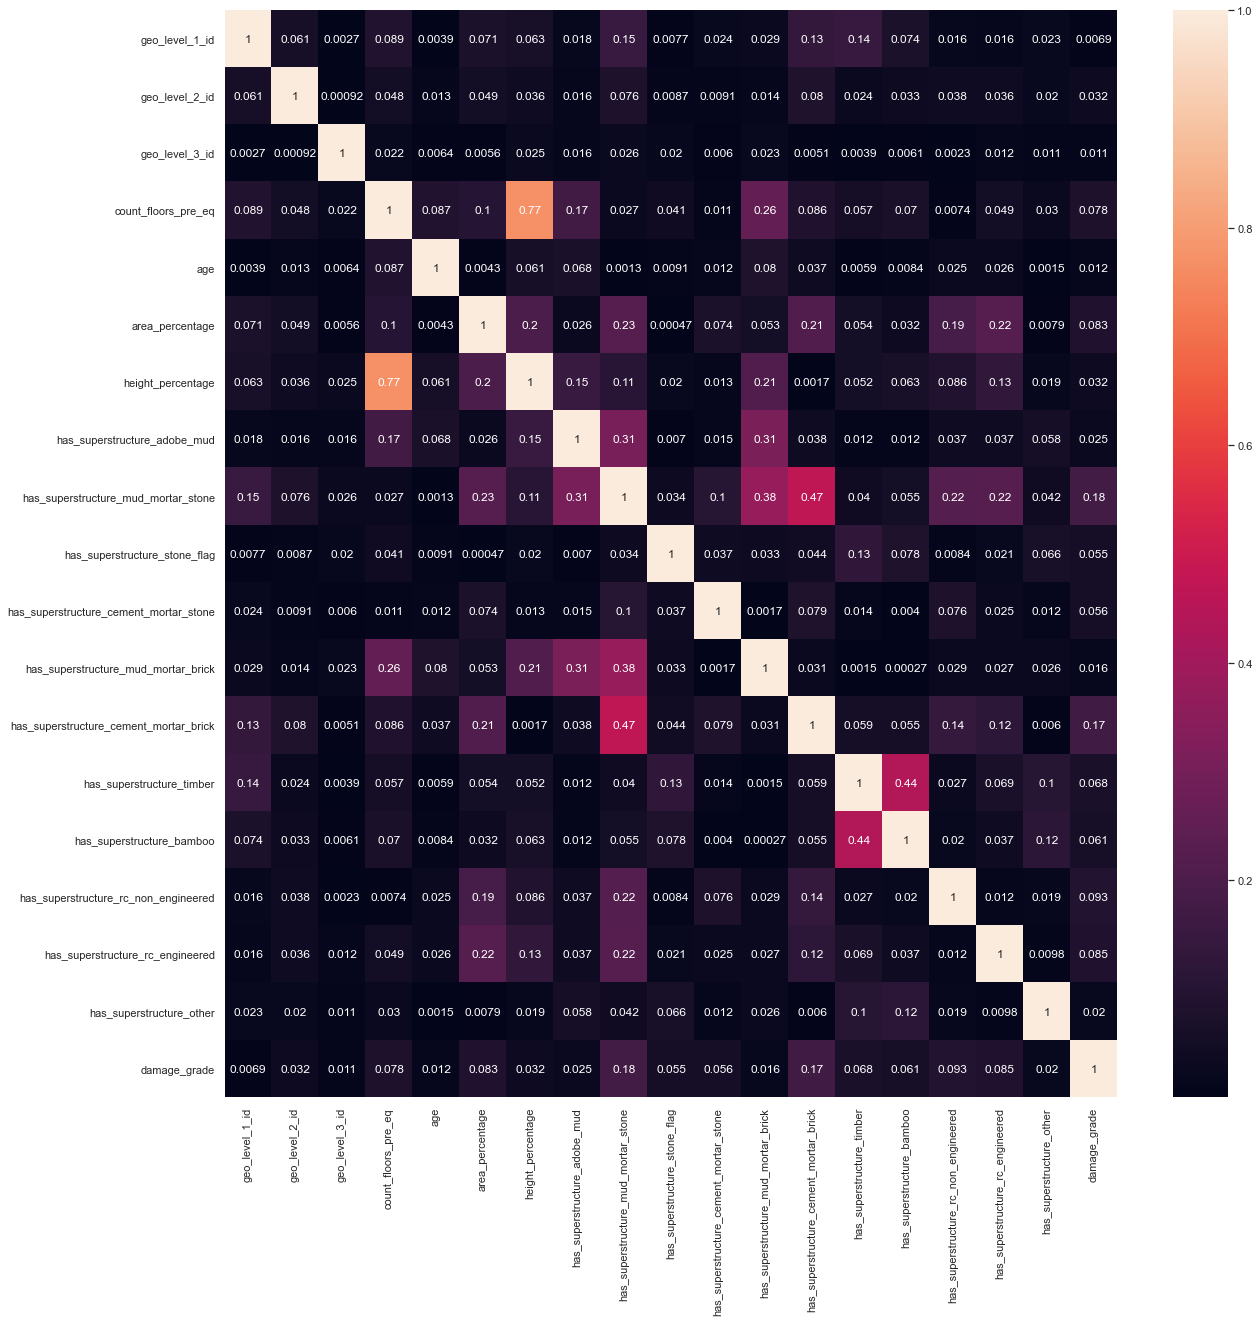

In [262]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(major_damage.corr().abs(),annot=True);

Because 'Height_percentage' and 'count_floors_pre_eq' are highly collinear with each other, we decided to drop 'count_floors_pre_eq' as 'height_percentage' is more useful in determining the overall height of a building.

In [63]:
major_damage = major_damage.drop('count_floors_pre_eq', axis = 1)

As Geographical location should not be a factor in predicting damage for future earthquakes (Focus on areas with tectonic plates),
as well as the position of the house (direction the house is facing), along with the plan configuration of the house, those features were left from our dataset.

In [64]:
major_damage = major_damage.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'position', 'plan_configuration'], axis = 1)

# Feature Importance

For the remaining object types, we converted them into a categorical so we can pass the dataset into a StandardScaler to find the most important features

In [65]:
# Unable to Determine
def foundation(val):
    if val == 'r':
        return 1
    elif val == 'u':
        return 2
    elif val == 'w':
        return 3
    elif val == 'h':
        return 4
    elif val == 'i':
        return 5

# t = flat, n = Moderate, 3 = steep
def land_type(val):
    if val == 't':
        return 1
    elif val == 'n':
        return 2
    else:
        return 3

# q = Reinforced cement concrete slabs, n = bamboo, x = other  
def roof(val):
    if val == 'n':
        return 1
    elif val == 'q':
        return 2
    elif val == 'x':
        return 3
# Unable to Determine   
def floor_type(val):
    if val == 'f':
        return 1
    elif val == 'x':
        return 2
    elif val == 'v':
        return 3
    elif val == 'z':
        return 4
    elif val == 'm':
        return 5
    
# Unable to Determine
def floor_type_2(val):
    if val == 'q':
        return 1
    elif val == 'x':
        return 2
    elif val == 'j':
        return 3
    elif val == 's':
        return 4

Map the columns accoringing to their defined functions.

In [66]:
major_damage['foundation_type'] = major_damage['foundation_type'].map(foundation)
major_damage['land_surface_condition'] = major_damage['land_surface_condition'].map(land_type)
major_damage['roof_type'] = major_damage['roof_type'].map(roof)
major_damage['ground_floor_type'] = major_damage['ground_floor_type'].map(floor_type)
major_damage['other_floor_type'] = major_damage['other_floor_type'].map(floor_type_2)

### After The Transformations, This Is The Dataset We Will Use to Determine Feature Importance.

In [35]:
major_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 20 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     260601 non-null  int64
 1   area_percentage                         260601 non-null  int64
 2   height_percentage                       260601 non-null  int64
 3   land_surface_condition                  260601 non-null  int64
 4   foundation_type                         260601 non-null  int64
 5   roof_type                               260601 non-null  int64
 6   ground_floor_type                       260601 non-null  int64
 7   other_floor_type                        260601 non-null  int64
 8   has_superstructure_adobe_mud            260601 non-null  int64
 9   has_superstructure_mud_mortar_stone     260601 non-null  int64
 10  has_superstructure_stone_flag           260601 non-null  int64


In [55]:
len(major_damage[major_damage['height_percentage'] > 11])

2434

We noticed that 'height_percentage' is normalized, however there are values over 10, which would mean it is an input error. Because the size of the input errors are limited, we decided it best to drop them instead of guessing what the original value is.

In [37]:
major_damage = major_damage[major_damage['height_percentage'] < 11]

Same goes for area_percentage, although the size was a bit larger this time

In [56]:
len(major_damage[major_damage['area_percentage'] > 11])

34604

In [39]:
major_damage = major_damage[major_damage['area_percentage'] < 11]

## Feature Engineering

To create a better model, engineering a feature could prove helpful. For the 'skinny_tall' column, I grouped buildings that were taller than average, but had a smaller than average base, together.

In [67]:
engineered_features = major_damage

In [68]:
engineered_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 20 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     260601 non-null  int64
 1   area_percentage                         260601 non-null  int64
 2   height_percentage                       260601 non-null  int64
 3   land_surface_condition                  260601 non-null  int64
 4   foundation_type                         260601 non-null  int64
 5   roof_type                               260601 non-null  int64
 6   ground_floor_type                       260601 non-null  int64
 7   other_floor_type                        260601 non-null  int64
 8   has_superstructure_adobe_mud            260601 non-null  int64
 9   has_superstructure_mud_mortar_stone     260601 non-null  int64
 10  has_superstructure_stone_flag           260601 non-null  int64


In [81]:
engineered_features['skinny_tall'] = (engineered_features['height_percentage'] > 5) \
                                      & (engineered_features['area_percentage'] < 5)

In [82]:
def boolean(val):
    if val == False:
        return 0
    elif val == True:
        return 1
    
engineered_features['skinny_tall'] = engineered_features['skinny_tall'].map(boolean)

Check for multicollinearity issues once more before exporting the data for modeling.

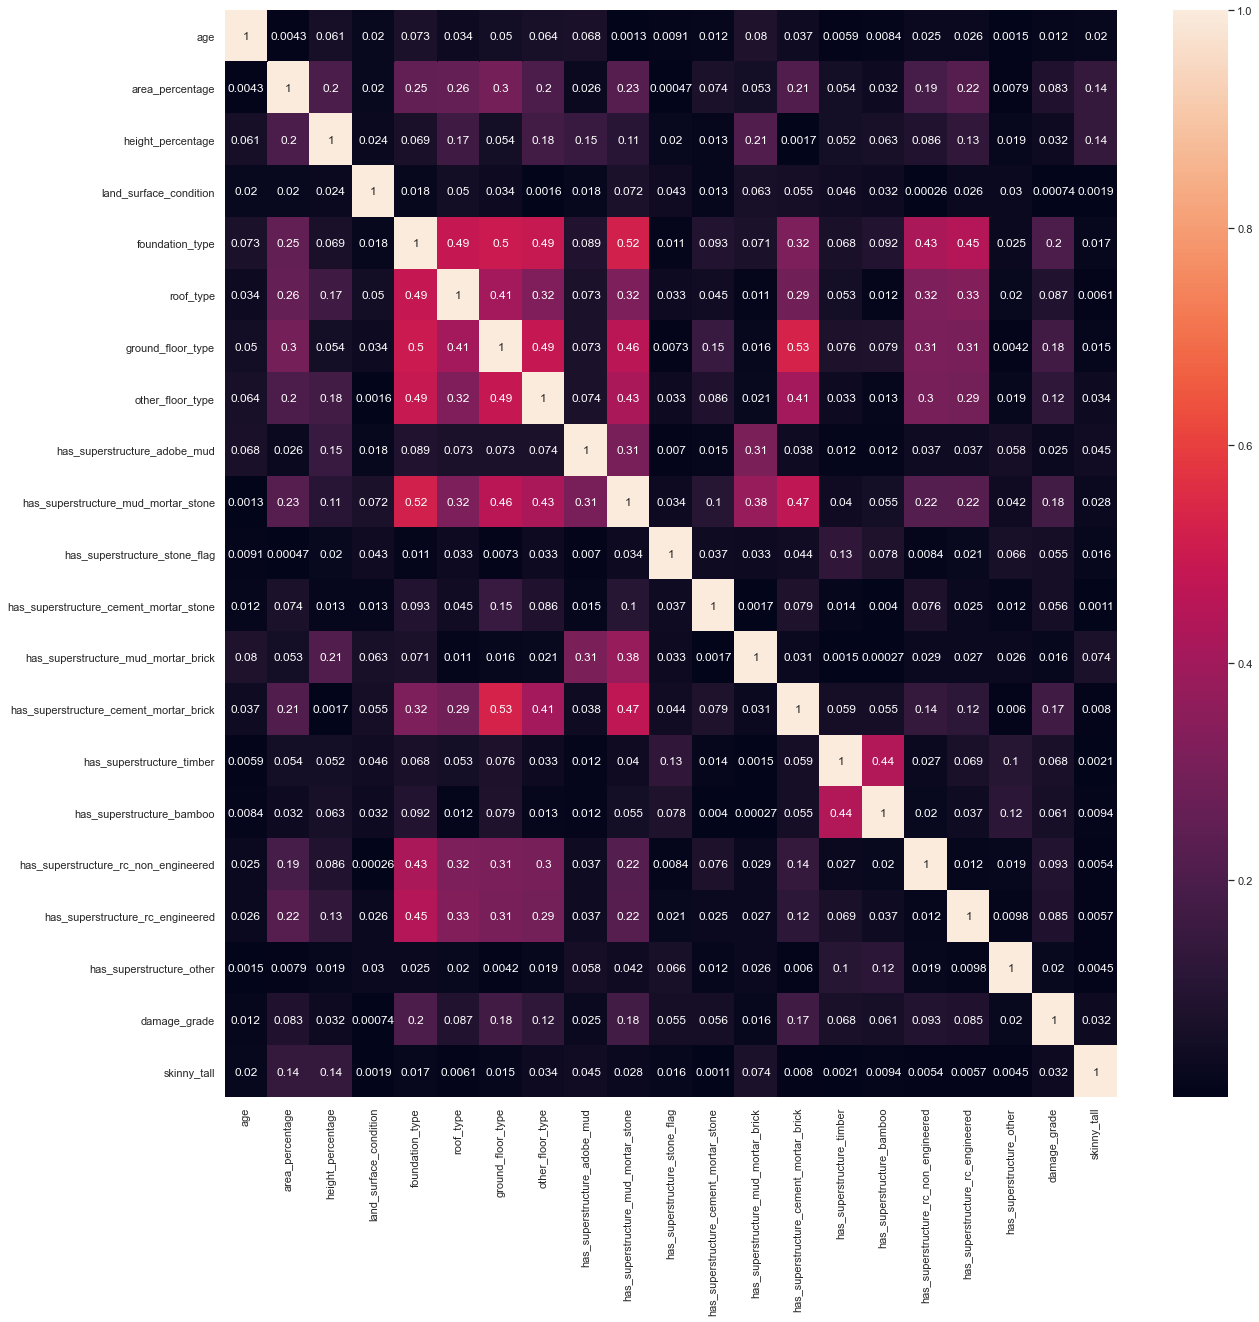

In [17]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(engineered_features.corr().abs(),annot=True);

In [83]:
skinny_tall = engineered_features[engineered_features['skinny_tall'] == 1]

In [84]:
skinny_tall['damage_grade'].value_counts(normalize = True)

0    0.53383
1    0.46617
Name: damage_grade, dtype: float64

Save as a csv for ease of comparison in our modeling notebook.

In [61]:
engineered_features.to_csv('engineered_features.csv')

When tested using the Random Forest Classifier, the engineered_features.csv datafile increased the accuracy by about 0.05, or half a percent. Although it may not be the greatest improvement, half a percent at a massive scale could end up saving thousands if not millions of dollars.

In [55]:
major_damage.to_csv('major_damage.csv')

### Train-Test Split For Feature Selection

In [62]:
X_train, X_test, y_train, y_test = train_test_split(major_damage.drop('damage_grade', axis=1), major_damage['damage_grade'], test_size=0.25, random_state=1)

In [63]:
# Instantiate Standard Scaler
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Using SelectKBest to Extract Important Features

In [64]:
X = major_damage.drop('damage_grade', axis = 1) 
y = major_damage['damage_grade'] 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

                                     Specs        Score
0                                      age  4149.974640
13  has_superstructure_cement_mortar_brick  3943.739481
4                          foundation_type  2419.693372
14               has_superstructure_timber  1196.193888
15               has_superstructure_bamboo  1016.157332


SelectKBest determined features ['Age', 'has_superstructure_cement_mortar_brick', 'foundation_type', 'area_percentage'] as the most important features.

### Using Random Forest and Extra Trees Classifier To Determine Feature Importance

In [65]:
feature_names = [f"feature {i}" for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [66]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.089 seconds


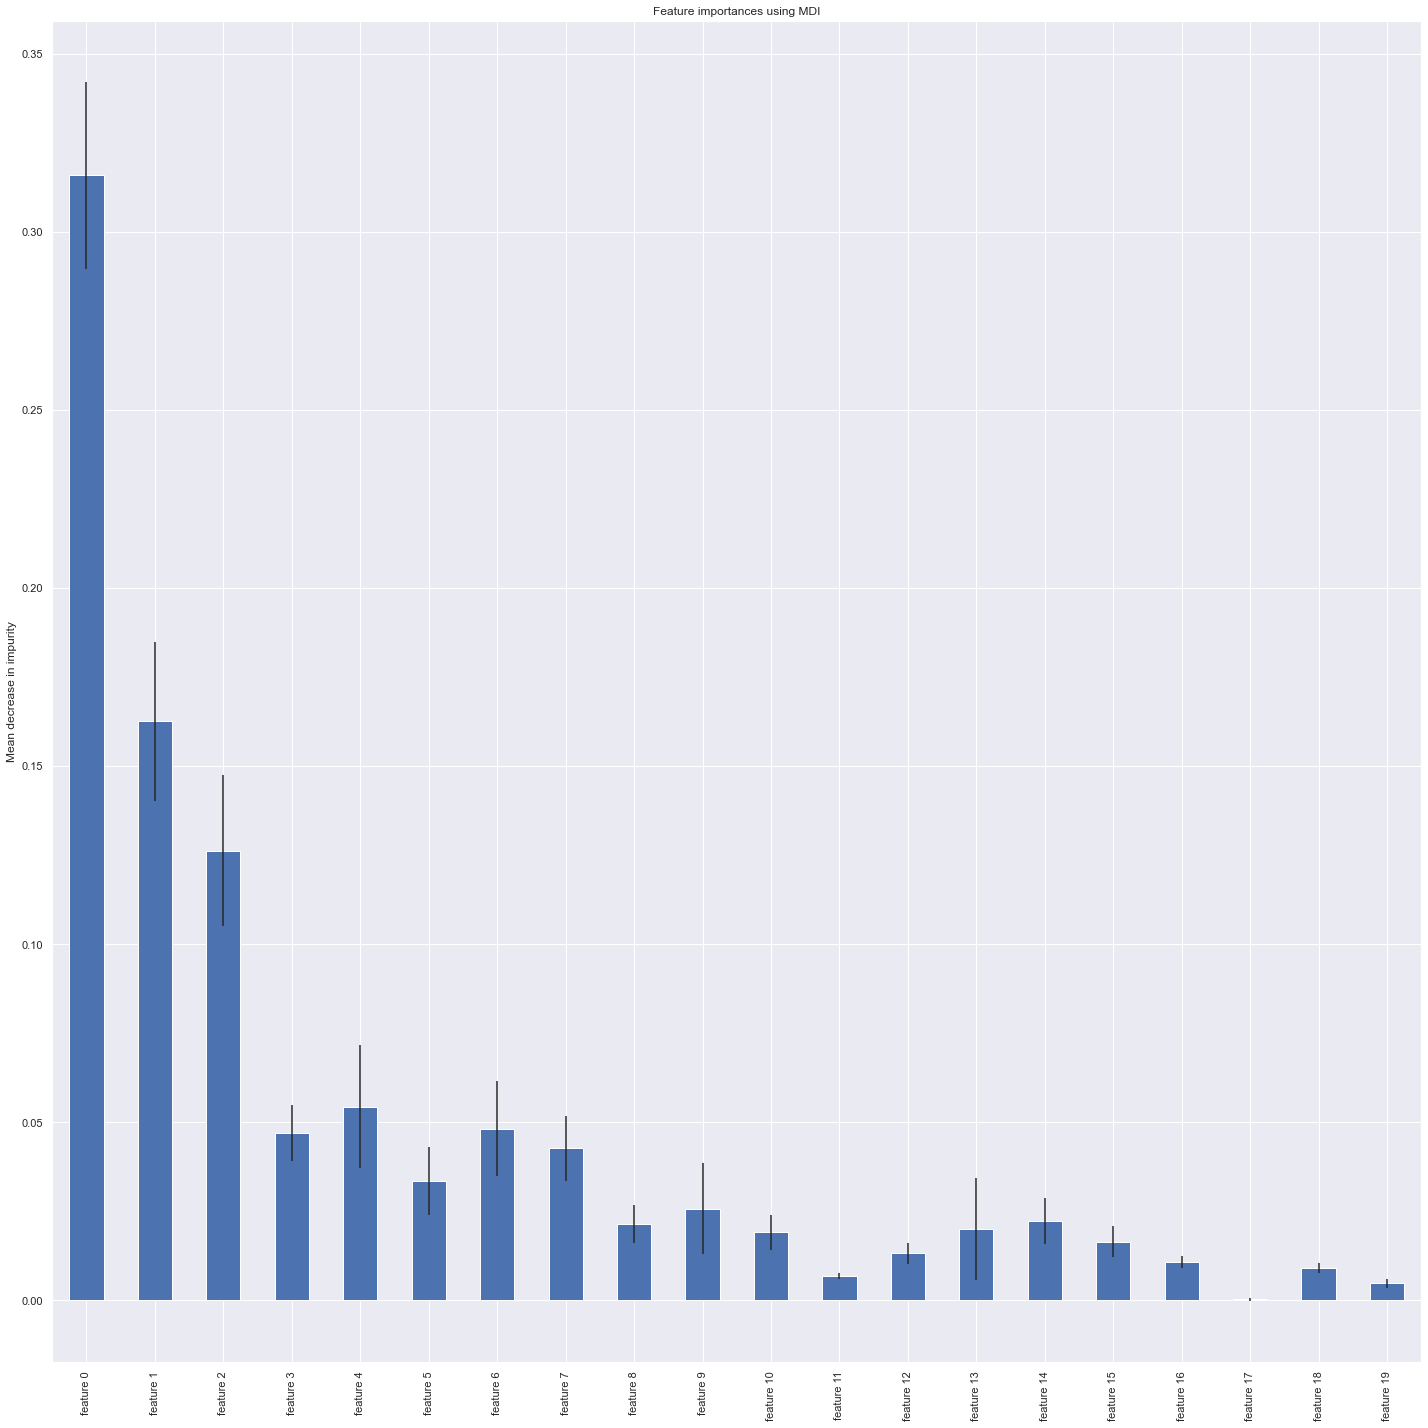

In [67]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Imputation to find most important features

In [57]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 124.155 seconds


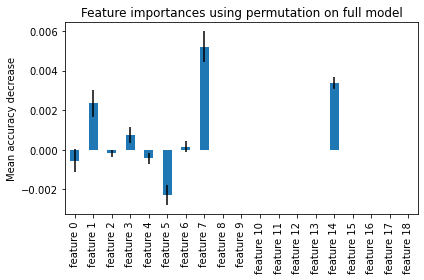

In [58]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Results were difficult to understand, so we left imputation and use the first graph for explainability.

Random Forest Determined Features ['Age', 'Area_percentage', 'Height_percentage'] as highest important features.


### Extra Trees

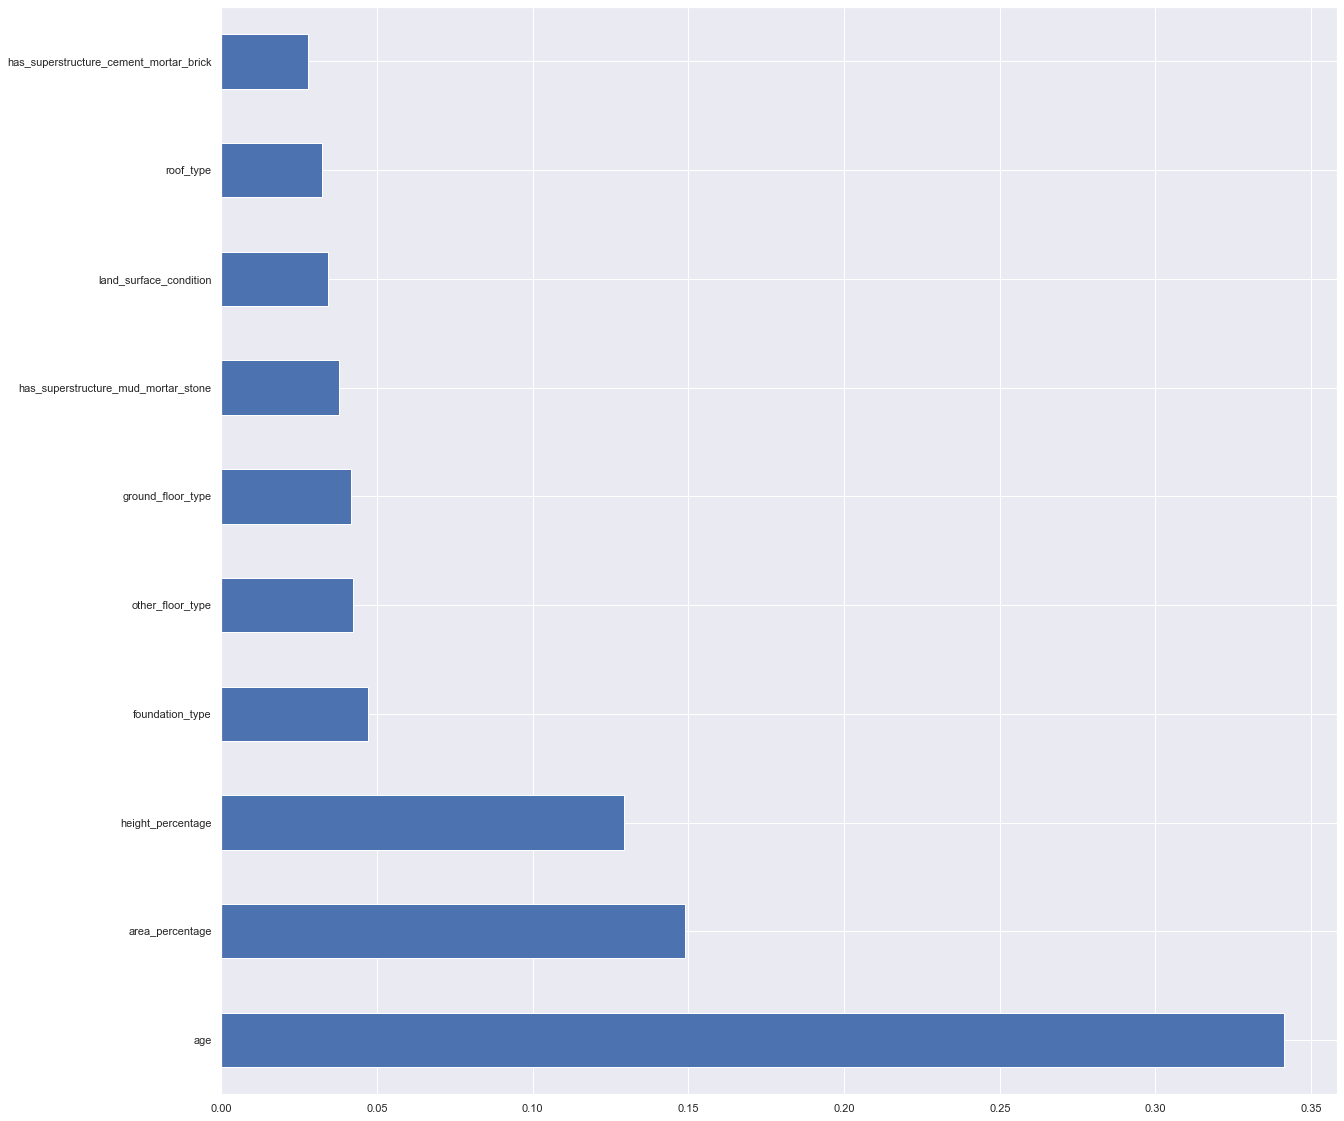

In [68]:
model = ExtraTreesClassifier()
model.fit(X,y)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Extra Trees Classifier Determined Features ['Age', 'Area_percentage', Height_perentage'] as the most important features.

This follows logical sense as Random Forest and Extra Trees work essentially in the same way. Lets use one more estimator to help determine the most important features.

## Logistic Regression for Feature Importance

Feature: 0, Score: -0.00015
Feature: 1, Score: -0.05839
Feature: 2, Score: 0.08221
Feature: 3, Score: -0.07910
Feature: 4, Score: -0.51446
Feature: 5, Score: 0.17135
Feature: 6, Score: -0.23657
Feature: 7, Score: 0.09622
Feature: 8, Score: 0.31801
Feature: 9, Score: 0.43145
Feature: 10, Score: 0.89044
Feature: 11, Score: -0.31864
Feature: 12, Score: -0.12758
Feature: 13, Score: -1.16139
Feature: 14, Score: -0.29699
Feature: 15, Score: -0.28566
Feature: 16, Score: -0.22504
Feature: 17, Score: -0.05907
Feature: 18, Score: -0.10760
Feature: 19, Score: 0.11564


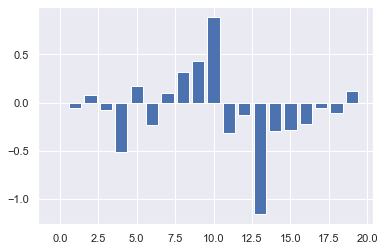

In [71]:
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

In [72]:
major_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210328 entries, 802906 to 747594
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     210328 non-null  int64
 1   area_percentage                         210328 non-null  int64
 2   height_percentage                       210328 non-null  int64
 3   land_surface_condition                  210328 non-null  int64
 4   foundation_type                         210328 non-null  int64
 5   roof_type                               210328 non-null  int64
 6   ground_floor_type                       210328 non-null  int64
 7   other_floor_type                        210328 non-null  int64
 8   has_superstructure_adobe_mud            210328 non-null  int64
 9   has_superstructure_mud_mortar_stone     210328 non-null  int64
 10  has_superstructure_stone_flag           210328 non-null  int64


Features 10 and 13 have abnormally high and low scores, respectively. Feature 14, superstructure_cement_mortar_brick came up again from SelectKBest. Feature 11 was superstructure_stone_flag, if the structure had a superstructure made of stone.

In [287]:
major_damage['has_superstructure_cement_mortar_brick'].value_counts(normalize = True)

0    0.927615
1    0.072385
Name: has_superstructure_cement_mortar_brick, dtype: float64

In [288]:
major_damage['has_superstructure_stone_flag'].value_counts(normalize = True)

0    0.965629
1    0.034371
Name: has_superstructure_stone_flag, dtype: float64

From this data, building's superstructure that were not made out of cement mortar - brick or stone, the building had a high likelyhood of being completely destroyed

#### The Most Important Features Were The Buildings Age, Superstructure Type, and Height Percentage.

In [121]:
stone_super = major_damage[major_damage['has_superstructure_cement_mortar_brick'] == 1]
stone_super['damage_grade'].value_counts(normalize = True)

0    0.944434
1    0.055566
Name: damage_grade, dtype: float64

In [123]:
stone_super = major_damage[major_damage['has_superstructure_rc_engineered'] == 1]
stone_super['damage_grade'].value_counts(normalize = True)

0    0.980769
1    0.019231
Name: damage_grade, dtype: float64